# bottom-up continuous likelihoods

## flow fields

In [2]:
import numpy as np
import os, sys

# project_root = os.getcwd()
project_root = os.path.abspath("")  # alternative
base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # makes fonts editable in Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42

model loaded!


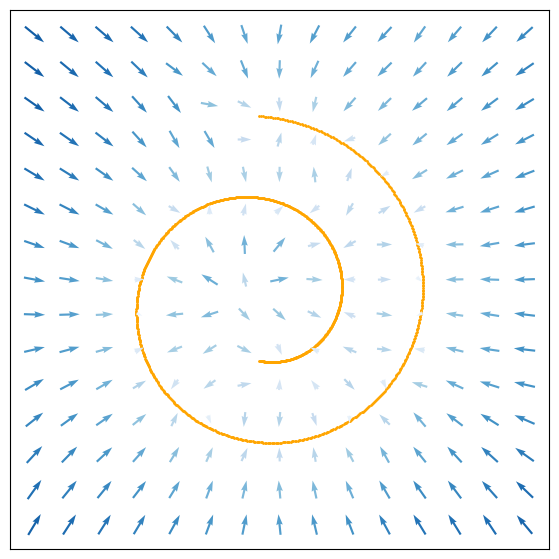

In [3]:
# display the flow field for the prior sampler 

from dataset_utils import generate_2d_swiss_roll
num_samples_in_gt_manifold = 1e3
dataset = generate_2d_swiss_roll(num_samples_in_gt_manifold, True)[1]

# ----------------- calculate flow field for diffusion model ----------------- #
from utils import select_model
prior_sampler = select_model('unconditional-dendritic', 47)[0]

lim=1.5
num_vectors_per_dim=15
from likelihood_utils import calculate_prior_score_flow_field
score_xs, score_ys, color = calculate_prior_score_flow_field(prior_sampler, lim, num_vectors_per_dim, t=0.25)

# ----------------------------------- plot ----------------------------------- #
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.scatter(*dataset[:, :2].T, s=1, alpha=1, c='orange')
q = ax.quiver(np.linspace(-lim, lim, num_vectors_per_dim), np.linspace(-lim, lim, num_vectors_per_dim), 
          score_xs, score_ys, 
          color,
          cmap='Blues',
          angles='xy', scale_units='xy', pivot='mid',
          scale=12,
          clim=(0, 4))
ax.set_aspect('equal')
from utils import remove_all_ticks_and_labels
_=remove_all_ticks_and_labels(ax)

from plot import save_fig
save_fig(fig, 'figure2-prior')

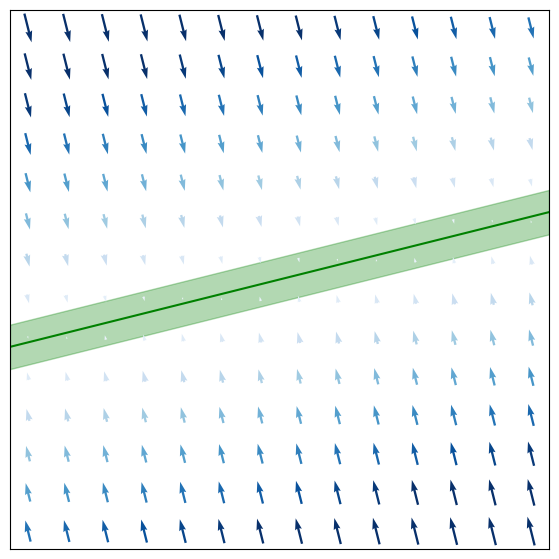

In [4]:
# display the flow field for the continuous likelihood

# ------------------------- likelihood model details ------------------------- #
v = np.array([[4, 1]]).T  # constraint vector
M = v / np.linalg.norm(v)
Mm = M @ M.T  # projection matrix
Mm = torch.from_numpy(Mm).float()
constraint_sigma = 0.06

# --------------- calculate flow field for the likelihood model -------------- #
from likelihood_utils import compute_occlusion_score_flow_field
lims=[-lim, lim]
x_hyps, scores, color = compute_occlusion_score_flow_field(Mm, t=1)

# ----------------------------------- plot ----------------------------------- #
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.set(xlim=lims, ylim=lims)
# show the linear constraint along with its standard deviation
from plot import draw_constraint_line
draw_constraint_line(ax, v, constraint_sigma, lim)
ax.quiver(*x_hyps.T, *scores.T,
            color,
            cmap="Blues",
            angles = 'xy',
            scale_units = 'width',
            scale = 25,
            pivot = 'mid',
            clim=(-.05, 1.4)
            )
ax.set_aspect('equal')
_ = remove_all_ticks_and_labels(ax)

from plot import save_fig
save_fig(fig, 'figure2-llh')

## comparison of reverse processes
samples generated by iid diffusion reverse process, compared against those generated by sequential neural reverse process

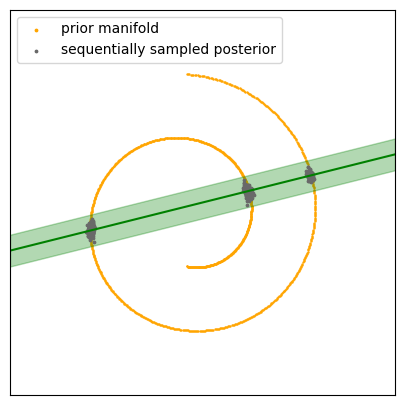

In [5]:
v = np.array([[4, 1]]).T
M = v / np.linalg.norm(v)
likelihood_sigma = 0.1
s = 0.1
num_cycles = 1000

# initialize a random point on the ground truth manifold and start the sequential posterior sampling
num_samples_in_gt_manifold = 1000
dataset = generate_2d_swiss_roll(num_samples_in_gt_manifold, rescaled=True)[1]
manifold_initial_point = dataset[np.random.randint(num_samples_in_gt_manifold)].reshape(1, -1)
# samples_seq, seq_reverse_samples = sequential_posterior_sampler(prior_sampler, manifold_initial_point, M, likelihood_sigma, s, num_cycles, n_steps=100)

# load previously generated samples
import zarr
data_dir_llh = os.path.join(base_dir, 'core/saved_arrays/likelihood')
samples_seq = zarr.load(os.path.join(data_dir_llh, 'samples_seq.zarr'))
samples_seq_reverse = zarr.load(os.path.join(data_dir_llh, 'samples_seq_reverse_process.zarr'))

# plot the results of the sequential posterior sampling
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.set(xlim=lims, ylim=lims)
ax.scatter(*dataset[500].T, s=3, alpha=1, c='orange', label='prior manifold')
ax.scatter(*dataset.T, s=0.5, alpha=1, c='orange')
draw_constraint_line(ax, v, constraint_sigma, lim)

ax.scatter(*samples_seq.T, s=3, c='dimgrey', label='sequentially sampled posterior')
ax.set_aspect('equal')
ax.legend(loc="upper left")
a = remove_all_ticks_and_labels(ax)

In [6]:
# generate iid samples from a standard diffusion model, starting from samples from a normal distribution with identity covariance
from utils import select_model
prior_sampler, num_steps, ambient_dims = select_model('unconditional-dendritic', 47)

from likelihood_utils import posterior_sample_loop_occlusion
sample_size = int(5e2)
samples_iid_reverse = posterior_sample_loop_occlusion(prior_sampler, M, likelihood_sigma, s, (sample_size, ambient_dims), num_steps)

model loaded!


In [7]:
# sequential samples from the posterior that uses the continuous likelihood
from likelihood_utils import sequential_posterior_sampler
num_cycles = int(5e2)
manifold_initial_point = dataset[np.random.randint(num_samples_in_gt_manifold)].reshape(1, -1)
z_seq, samples_seq_reverse = sequential_posterior_sampler(prior_sampler, manifold_initial_point, M, likelihood_sigma, s, num_cycles)


Text(0.5, 0.98, 'sequential sampling from the posterior distribution')

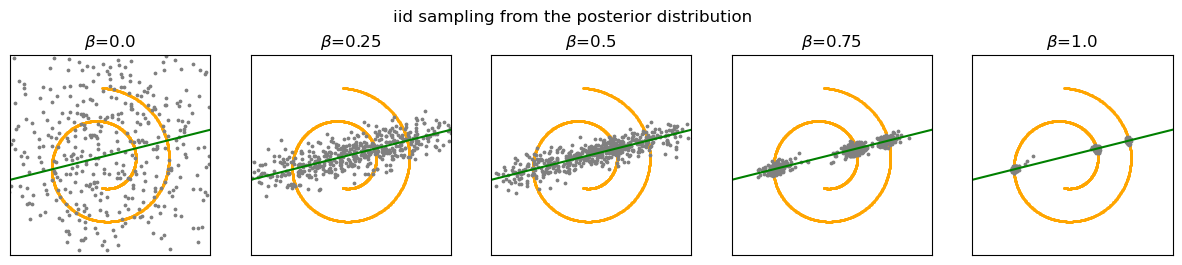

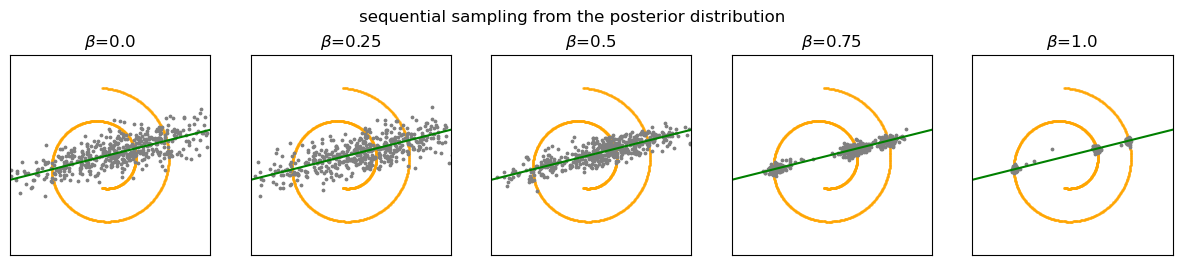

In [8]:
# plot the reverse process of the iid generated posterior samples at different temperatures
fig, ax = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
idx = 0
for i, temp in enumerate([0, 25, 50, 75, 100]):
    ax[i].scatter(*dataset.T, s=1, c='orange')
    ax[i].scatter(*samples_iid_reverse[int(temp)].T, s=3, c='grey', label='$p(z_t\,|\,M^T z_t)$')
    draw_constraint_line(ax[i], v, constraint_sigma, lim, show_stdev=False)
    ax[i].set(title=f'$\\beta$={int(temp)/100}')
    ax[i].set_aspect('equal')
    ax[i].set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax[i])
fig.suptitle('iid sampling from the posterior distribution')


# plot the reverse process of the sequentially generated posterior samples at different temperatures
fig, ax = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
for idx, temp in enumerate([0, 25, 50, 75, 100]):
    ax[idx].scatter(*dataset.T, s=1, alpha=0.5, c='orange')
    ax[idx].scatter(*samples_seq_reverse[:, int(temp)].T, s=3, c='grey', label='$p(z_t\,|\,M^T z_t)$')
    draw_constraint_line(ax[idx], v, constraint_sigma, lim, show_stdev=False)
    ax[idx].set(title=f'$\\beta$={int(temp)/100}')
    ax[idx].set_aspect('equal')
    ax[idx].set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax[idx])
fig.suptitle('sequential sampling from the posterior distribution')

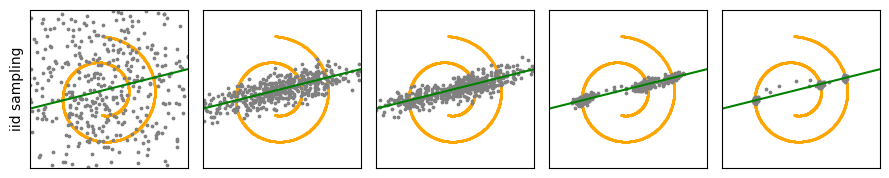

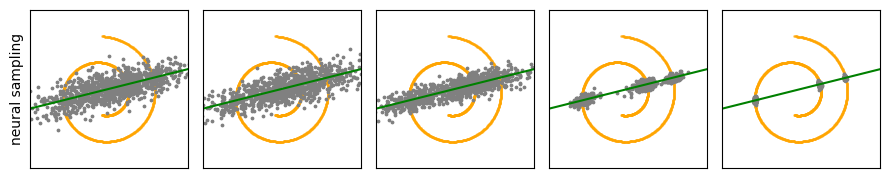

In [62]:
fig, ax = plt.subplots(1, 5, figsize=(9, 3), sharex=True, sharey=True)
idx = 0
for i, temp in enumerate([0, 25, 50, 75, 100]):
    ax[i].scatter(*dataset.T, s=1, c='orange')
    ax[i].scatter(*samples_iid_reverse[int(temp)].T, s=3, c='grey', label='$p(z_t\,|\,M^T z_t)$')
    draw_constraint_line(ax[i], v, constraint_sigma, lim, show_stdev=False)
    ax[i].set_aspect('equal')
    ax[i].set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax[i])
ax[0].set(ylabel='iid sampling')
fig.tight_layout()
save_fig(fig, 'figure2-iid-sampling')

# plot the reverse process of the sequentially generated posterior samples at different temperatures
fig, ax = plt.subplots(1, 5, figsize=(9, 3), sharex=True, sharey=True)
for idx, temp in enumerate([0, 25, 50, 75, 100]):
    ax[idx].scatter(*dataset.T, s=1, alpha=0.5, c='orange')
    ax[idx].scatter(*samples_seq_reverse[:, int(temp)].T, s=3, c='grey', label='$p(z_t\,|\,M^T z_t)$')
    draw_constraint_line(ax[idx], v, constraint_sigma, lim, show_stdev=False)
    ax[idx].set_aspect('equal')
    ax[idx].set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax[idx])
ax[0].set(ylabel='neural sampling')
fig.tight_layout()
save_fig(fig, 'figure2-neural-sampling')